## Supplement 3. find multiple change of mind trials.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from scipy import linalg
import os
import pickle
import matplotlib.pyplot as plt
from ripple_detection.core import segment_boolean_series

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SpikeSortingRecording,SpikeSortingRecordingSelection)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, RawPosition, IntervalLinearizedPosition, TrackGraph

[2025-02-26 12:11:51,683][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-02-26 12:11:51,717][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [3]:
from spyglass.shijiegu.load import load_run_sessions, load_decode, load_theta_maze
from spyglass.shijiegu.Analysis_SGU import TrialChoice,EpochPos,MUA,get_linearization_map, TrialChoiceChangeOfMind, DecodeResultsLinear
from spyglass.shijiegu.decodeHelpers import runSessionNames
from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking
from spyglass.shijiegu.changeOfMind import (insertTrialChoiceChangeOfMind, find_turnaround_time, findProportion,
            find_trials, load_epoch_data_wrapper, find_direction, find_trials_animal, unique_stable)
from spyglass.shijiegu.helpers import interpolate_to_new_time

from spyglass.shijiegu.theta import return_skaggs_theta
import matplotlib.patheffects as PathEffects
from spyglass.spikesorting.v0 import Curation
from spyglass.shijiegu.singleUnit import get_nwb_units, electrode_unit 
from spyglass.shijiegu.ripple_add_replay import select_subset_helper,select_subset_helper_pd

[12:11:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[12:11:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


### test

In [4]:
linear_map,node_location=get_linearization_map()

[12:11:58][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [6]:
nwb_copy_file_name = "lewis20240110_.nwb"
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Rev2Session1', '04_Rev2Session2', '06_Rev2Session3', '08_Rev2Session4', '10_Rev2Session5']


In [7]:
epoch_ind = 0
session_name = session_interval[epoch_ind]
position_name = position_interval[epoch_ind]

In [8]:
log_df = pd.read_pickle( (TrialChoiceChangeOfMind() & {"nwb_file_name": nwb_copy_file_name,
                                                           "epoch":int(session_name[:2])}).fetch1("change_of_mind_info") )
    

In [109]:
rowID = np.array(log_df[log_df.change_of_mind].index)
turnaround_times = np.array(log_df[log_df.change_of_mind].CoM_t)
turnaround_times_ind = np.array([ind for ind in np.arange(len(turnaround_times)) if len(turnaround_times[ind][0]) > 0])
rowID = rowID[turnaround_times_ind]
turnaround_times = turnaround_times[turnaround_times_ind]

In [112]:
len(rowID) == len(turnaround_times)

True

In [114]:
log_df

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,change_of_mind,CoMMaxProportion,CoM_t,CoM_arm,current,future_H,future_O,past,past_reward
1,1.704911e+09,1.0,1.704911e+09,1.0,2.0,False,[],[],[],1.0,1.0,3.0,NaN,NaN
2,1.704911e+09,1.0,1.704911e+09,3.0,1.0,False,[],[],[],3.0,3.0,2.0,1.0,1.0
3,1.704911e+09,1.0,1.704911e+09,2.0,2.0,False,[],[],[],2.0,2.0,4.0,3.0,1.0
4,1.704911e+09,1.0,1.704911e+09,4.0,2.0,False,[],[],[],4.0,4.0,1.0,2.0,2.0
5,1.704911e+09,1.0,1.704911e+09,1.0,1.0,False,[],[],[],1.0,1.0,3.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,1.704913e+09,1.0,1.704913e+09,2.0,2.0,False,[],[],[],2.0,2.0,3.0,4.0,1.0
79,1.704913e+09,1.0,1.704913e+09,3.0,1.0,False,[],[],[],3.0,3.0,4.0,2.0,2.0
80,1.704913e+09,1.0,1.704913e+09,4.0,2.0,False,[],[],[],4.0,4.0,3.0,3.0,2.0
81,1.704913e+09,1.0,1.704913e+09,3.0,2.0,True,0.511327,"[[1704913146.9024944, 1704913152.0024908]]","[[1, 2, 3, -9223372036854775808]]",3.0,3.0,NaN,4.0,4.0


In [117]:
turnaround_times = np.array(log_df.loc[rowID,'CoM_t'])

In [118]:
[tt[0] for tt in turnaround_times]

[[1704911404.3537314],
 [1704911507.9756577],
 [1704911533.3996396],
 [1704911612.4935834],
 [1704911747.133488,
  1704911749.5914862,
  1704911750.3574858,
  1704911754.5994828],
 [1704911855.6934109, 1704911860.6294074],
 [1704911987.9633172],
 [1704912136.5992115],
 [1704912325.3170776],
 [1704912705.7668076, 1704912706.620807],
 [1704912738.5767844, 1704912743.6787808],
 [1704912774.9007585, 1704912780.1227548],
 [1704912829.4247198, 1704912831.5467184],
 [1704913146.9024944, 1704913152.0024908]]

### end test

In [38]:
def find_multiple_CoM_session(nwb_copy_file_name, session_name, position_name):
    multiple_CoM_session = []
    """
    This function is finds rats multiple change of mind in more than 1 arms,
    """
    log_df = pd.read_pickle( (TrialChoiceChangeOfMind() & {"nwb_file_name": nwb_copy_file_name,
                                                           "epoch":int(session_name[:2])}).fetch1("change_of_mind_info") )
    for t in log_df.index[:-2]:
        if not log_df.loc[t,'change_of_mind']:
            continue
        
        CoM_time = np.array(log_df.loc[t,"CoM_t"][0])
        
        CoM_arm = np.array(log_df.loc[t,"CoM_arm"][0])
        CoM_arm = CoM_arm[CoM_arm > 0]

        if len(CoM_time) > 1 and len(CoM_arm) > 2:
            multiple_CoM_session.append((nwb_copy_file_name, session_name, position_name,t))

    return multiple_CoM_session, len(multiple_CoM_session), len(log_df) - 1, np.sum(log_df.change_of_mind)
            

15

In [169]:
animal = 'Eliot'
dates_to_plot = ['20221017','20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

In [46]:
animal = 'Lewis'
dates_to_plot = ['20240102','20240103','20240104','20240105','20240106','20240107','20240108','20240109',
                 '20240110','20240113','20240114','20240115','20240116','20240117','20240118','20240119','20240120']

In [47]:
animal = 'Haydn'
dates_to_plot = ['20230603','20230604','20230605','20230606','20230607','20230608']

### 1. Find multiple change of mind over learning curve

In [404]:
nwb_copy_file_name = "haydn20230608_.nwb"

In [405]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Rev3Session1', '04_Rev3Session2', '06_Rev3Session3', '08_Rev3Session4', '10_Rev3Session5']


In [44]:
def find_multiple_CoM_animal(animal,list_of_days):
    multiple_CoM = []
    multiple_CoM_count = {}
    total_trial = {}
    CoM_count = {}
    
    
    for day in list_of_days:
        nwb_file_name = animal.lower() + day + '.nwb'
        nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
        session_interval, position_interval = runSessionNames(nwb_copy_file_name)

        multiple_CoM_count[day] = 0
        total_trial[day] = 0
        CoM_count[day] = 0
        
        
        for ind in range(len(session_interval)):
            session_name = session_interval[ind]
            position_name = position_interval[ind]

            (multiple_CoM_session, multiple_CoM_count_session,
             total_trial_count_session, CoM_count_session)  = find_multiple_CoM_session(nwb_copy_file_name,
                                                                                           session_name,
                                                                                           position_name)
            if len(multiple_CoM_session)>0:
                multiple_CoM.append(multiple_CoM_session)
            multiple_CoM_count[day] += multiple_CoM_count_session
            CoM_count[day] += CoM_count_session
            total_trial[day] += total_trial_count_session
            
    return multiple_CoM, multiple_CoM_count, total_trial, CoM_count



In [45]:
animal = 'Eliot'
list_of_days = ['20221017','20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']
multiple_CoM, multiple_CoM_count, total_trial, CoM_count= find_multiple_CoM_animal(animal, list_of_days)

Text(0.5, 1.0, 'Eliot')

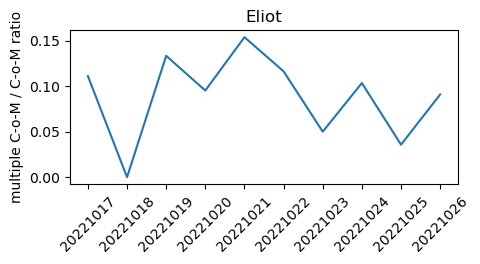

In [48]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 2),sharex=True)

ax1.plot([multiple_CoM_count[k]/CoM_count[k] for k in multiple_CoM_count])
#ax2.plot(np.array(trial_number) / np.array([total_trial_num[k] for k in total_trial_num]))

#ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('multiple C-o-M / C-o-M ratio');

ax1.set_xticks(np.arange(len(list_of_days)));
ax1.set_xticklabels(list_of_days, rotation = 45);
ax1.set_title(animal)

In [73]:
animal = 'Molly'
list_of_days = ['20220415','20220416','20220417','20220418','20220419','20220420']
multiple_CoM, multiple_CoM_count, total_trial, CoM_count= find_multiple_CoM_animal(animal, list_of_days)

Text(0.5, 1.0, 'Molly')

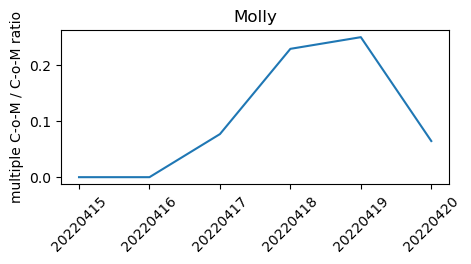

In [74]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 2),sharex=True)

ax1.plot([multiple_CoM_count[k]/CoM_count[k] for k in multiple_CoM_count])
#ax2.plot(np.array(trial_number) / np.array([total_trial_num[k] for k in total_trial_num]))

#ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('multiple C-o-M / C-o-M ratio');

ax1.set_xticks(np.arange(len(list_of_days)));
ax1.set_xticklabels(list_of_days, rotation = 45);
ax1.set_title(animal)

In [76]:
animal = 'Haydn'
list_of_days = ['20230603','20230604','20230605','20230606','20230607','20230608']
multiple_CoM, multiple_CoM_count, total_trial, CoM_count= find_multiple_CoM_animal(animal, list_of_days)

Text(0.5, 1.0, 'Haydn')

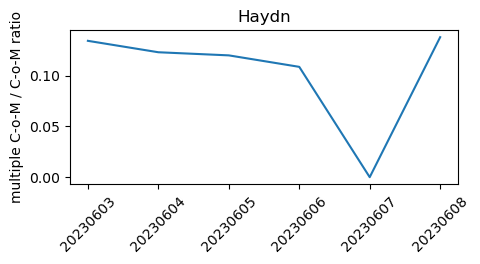

In [77]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 2),sharex=True)

ax1.plot([multiple_CoM_count[k]/(CoM_count[k]) for k in multiple_CoM_count])
#ax2.plot(np.array(trial_number) / np.array([total_trial_num[k] for k in total_trial_num]))

#ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('multiple C-o-M / C-o-M ratio');

ax1.set_xticks(np.arange(len(list_of_days)));
ax1.set_xticklabels(list_of_days, rotation = 45);
ax1.set_title(animal)

In [78]:
animal = 'Lewis'
list_of_days = ['20240102','20240103','20240104','20240105','20240106','20240107','20240108','20240109',
                 '20240110','20240113','20240114'] #'20240115','20240116','20240117','20240118','20240119','20240120'
multiple_CoM, multiple_CoM_count, total_trial, CoM_count= find_multiple_CoM_animal(animal, list_of_days)

Text(0.5, 1.0, 'Lewis')

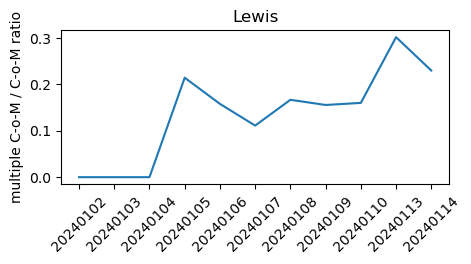

In [80]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 2),sharex=True)

ax1.plot([multiple_CoM_count[k]/(CoM_count[k]+1) for k in multiple_CoM_count])
#ax2.plot(np.array(trial_number) / np.array([total_trial_num[k] for k in total_trial_num]))

#ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('multiple C-o-M / C-o-M ratio');

ax1.set_xticks(np.arange(len(list_of_days)));
ax1.set_xticklabels(list_of_days, rotation = 45);
ax1.set_title(animal)

In [81]:
animal = 'Lewis'
list_of_days = ['20240115','20240116','20240117','20240118','20240119','20240120']
multiple_CoM, multiple_CoM_count, total_trial, CoM_count= find_multiple_CoM_animal(animal, list_of_days)

Text(0.5, 1.0, 'Lewis')

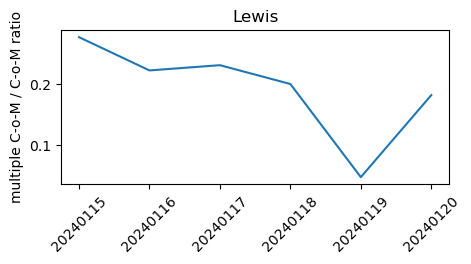

In [82]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 2),sharex=True)

ax1.plot([multiple_CoM_count[k]/(CoM_count[k]+1) for k in multiple_CoM_count])
#ax2.plot(np.array(trial_number) / np.array([total_trial_num[k] for k in total_trial_num]))

#ax1.text(0,0.5,animal,fontsize = 12)
ax1.set_ylabel('multiple C-o-M / C-o-M ratio');

ax1.set_xticks(np.arange(len(list_of_days)));
ax1.set_xticklabels(list_of_days, rotation = 45);
ax1.set_title(animal)

### 2. Do long theta seqeuences occur at the first or the last change of mind more?

In [462]:
bi = 9
backout_segment = nonbackout_segments_day[bi]
plottimes = (backout_segment[1][0]-2, backout_segment[1][1]+3)
(nwb_copy_file_name, session_name, position_name, t) = nonbackout_segments_day[bi][0]
print(plottimes)
print(nwb_copy_file_name, session_name, position_name, 'trial '+str(t))

IndexError: list index out of range

In [457]:
log_df = pd.read_pickle( (TrialChoiceChangeOfMind() & {"nwb_file_name": nwb_copy_file_name,
                                                           "epoch":int(session_name[:2])}).fetch1("change_of_mind_info") )
    
linear_position_info=(IntervalLinearizedPosition() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':position_name,
            'position_info_param_name':'default_decoding'}).fetch1_dataframe()
    
position_info = (IntervalPositionInfo() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':position_name,
            'position_info_param_name':'default_decoding'}).fetch1_dataframe()

# 3. load decode
decode = load_decode(nwb_copy_file_name,session_name,
                     decode_options["classifier_param_name"],decode_options["encoding_set"])
# 4. load spikes
curation_id = 1
from spyglass.shijiegu.singleUnit_sortedDecode import place_field_direction, color_cells_by_place_direction

(cells, smoothed_placefield, placefield_peak,
        spike_count_by_arm_direction, time_spent_by_arm_direction, betaPdfs, means) = place_field_direction(nwb_copy_file_name,
                                                                                session_name,position_name,
                                                                                curation_id = curation_id)
cell_color = color_cells_by_place_direction(cells, placefield_peak, spike_count_by_arm_direction)

sort_group_ids = np.unique((Curation() & {'nwb_file_name': nwb_copy_file_name,
                                              "curation_id":1}).fetch("sort_group_id"))

nwb_units_all = get_nwb_units(
            nwb_copy_file_name,session_name,sort_group_ids,curation_id = curation_id)

[22:35:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[22:35:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [458]:
log_df.loc[t]

timestamp_H                       1686265503.01456
Home                                           1.0
timestamp_O                      1686265518.864572
OuterWellIndex                                 3.0
rewardNum                                      2.0
change_of_mind                                True
CoMMaxProportion                               1.0
CoM_t                        [[1686265513.674576]]
CoM_arm             [[1, 3, -9223372036854775808]]
current                                        3.0
future_H                                       3.0
future_O                                       2.0
past                                           2.0
past_reward                                    4.0
Name: 53, dtype: object

In [459]:
import scipy.signal as ss
#theta_df, pos1d, pos2d = return_skaggs_theta(nwb_copy_file_name,position_name,session_name,
#                                             nwb_units_all,cells)
#theta_df.index.name='time'
#theta_df=xr.Dataset.from_dataframe(theta_df)

theta_xr = load_theta_maze(nwb_copy_file_name,session_name)
theta_xr = theta_xr.assign(phase0=('time',np.angle(ss.hilbert(theta_xr[0]))))
#theta_xr = theta_xr.assign(phase1=('time',np.angle(ss.hilbert(theta_xr[1]))))
theta_df = theta_xr.to_dataframe()

In [460]:
results_subset = select_subset_helper(decode,plottimes)
#head_direction_sign_subset = select_subset_helper_pd(head_direction_sign,plottimes)
#theta_xr_subset = select_subset_helper(theta_xr,plottimes)
#theta_df = theta_xr_subset.to_dataframe()

posterior_position_subset=results_subset.causal_posterior.sum(
        dim='state')
theta_subset = select_subset_helper(theta_xr,plottimes) 
theta_subset = theta_subset.to_dataframe()

linear_position_xr=xr.Dataset.from_dataframe(linear_position_info)
linear_position_subset= select_subset_helper(linear_position_xr,plottimes)


cells_fired = []
"""
for cell in cells:
    (e,u) = cell
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id = curation_id)
    spike_times = nwb_units.loc[u].spike_times
    spike_times = spike_times[np.logical_and(spike_times >= plottimes[0],spike_times <= plottimes[1])]
    if len(spike_times) > 0:
        cells_fired.append(cell)
"""

'\nfor cell in cells:\n    (e,u) = cell\n    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id = curation_id)\n    spike_times = nwb_units.loc[u].spike_times\n    spike_times = spike_times[np.logical_and(spike_times >= plottimes[0],spike_times <= plottimes[1])]\n    if len(spike_times) > 0:\n        cells_fired.append(cell)\n'

Text(0.5, 1.0, 'speed')

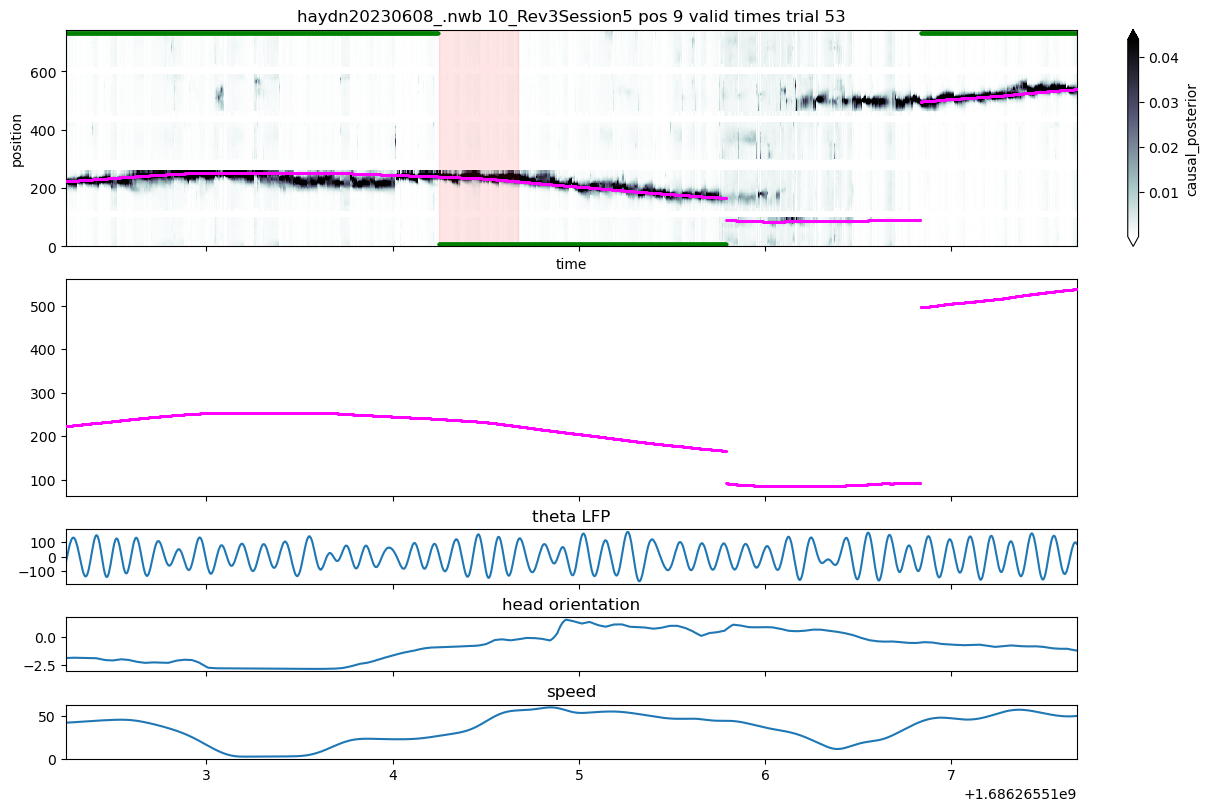

In [461]:
fig, axes = plt.subplots(5, 1, figsize=(12, 8), sharex=True,
                             constrained_layout=True,gridspec_kw={"height_ratios": [2,2,0.5,0.5,0.5]})
posterior_position_subset.plot(x='time', y='position', ax=axes[0], rasterized=True, robust=True, cmap='bone_r')
for cell in cells_fired:
    e = cell[0]
    u = cell[1]
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,e,curation_id = curation_id)

    spike_times = nwb_units.loc[u].spike_times
    spike_times = spike_times[np.logical_and(spike_times >= plottimes[0],spike_times <= plottimes[1])]

    if cell_color[(e,u)] == "k":
        cell_color[(e,u)] = "C2"

    axes[1].scatter(spike_times, np.zeros(len(spike_times)) + placefield_peak[(e,u)],
                    rasterized=True, marker='|', color = cell_color[(e,u)],alpha = 0.5)
    if len(spike_times) > 0:
        txt = axes[1].text(spike_times[0],placefield_peak[(e,u)],str((e,u)),rotation = 10, color = cell_color[(e,u)])
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='w',alpha = 0.8)])

theta_d0=np.array(np.array(theta_subset[0])).astype('int32').T
#theta_d1=np.array(np.array(theta_subset[1])).astype('int32').T
theta_t=np.array(theta_subset.index)
axes[2].plot(theta_t,theta_d0)
#axes[2].plot(theta_t,theta_d1)
axes[2].set_title('theta LFP')


axes[0].scatter(linear_position_subset.time,
                np.array(linear_position_subset.linear_position),
                s=1, color='magenta', zorder=10)

axes[1].scatter(linear_position_subset.time,
                np.array(linear_position_subset.linear_position),
                s=1, color='magenta', zorder=10)
axes[0].axvspan(backout_segment[1][0], backout_segment[1][1], color = "red", alpha = 0.1)


trialInd = (linear_position_info.index >= plottimes[0]) & (linear_position_info.index <= plottimes[1])
trialInfo = linear_position_info.loc[trialInd]
trialInfo2D = position_info.loc[trialInd]
        
arm_direction_t, arm_direction, all_arms_direction = find_direction(trialInfo, trialInfo2D)
head_direction_sign = pd.Series(arm_direction, index = arm_direction_t)

axes[0].scatter(head_direction_sign.index,
        (head_direction_sign + 1) * 360 + 10, #so the top line is at 700
        s = 3, c = 'green')
axes[0].set_title(nwb_copy_file_name + ' ' + session_name + ' ' + position_name + ' ' + 'trial '+str(t))
axes[3].plot(trialInfo2D.index, trialInfo2D.head_orientation)
axes[3].set_title("head orientation")
axes[4].plot(trialInfo2D.index, trialInfo2D.head_speed)
axes[4].set_title("speed")